In [37]:
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [38]:
df = pd.read_csv("data_gyeonggi.csv")
df.head()

,date,confirmed,death,released,weather_temp,weather_rain,social_keyword_corona,social_keyword_disinfection,social_keyword_mask,social_keyword_infection,social_keyword_briefing,date_red,traffic_subway,confirmed_foreign,group_total,PM10
0,20200301,7,0,0,5.6,0.0,288841,19264,105352,17744,3281,1,1469158,0,0,45
1,20200302,3,0,0,4.6,0.0,341923,32023,202509,17089,3581,0,4162674,0,0,41
2,20200303,2,0,0,5.1,0.0,315235,30640,203550,19368,3270,0,4168576,0,0,49
3,20200304,7,0,0,3.7,0.0,300534,32469,174302,28207,4067,0,4163524,0,0,45
4,20200305,9,0,2,2.5,0.0,278765,26606,161861,26839,3288,0,4185111,0,4,37


In [39]:
from sklearn.model_selection import train_test_split

In [81]:
x = df[['death', 'released', 'weather_temp', 'weather_rain', 'social_keyword_corona', 'social_keyword_disinfection', 'social_keyword_mask', 'social_keyword_infection', 'social_keyword_briefing', 'date_red', 'traffic_subway', 'confirmed_foreign', 'group_total', 'PM10']]
y = df[['confirmed']]

x_train, x_test, y_train, y_test = train_test_split(x,y, train_size=0.9, test_size=0.1)

In [82]:
#### Normalize
mean = x_train.mean(axis=0)
std = x_train.std(axis=0)
x_train = (x_train - mean)/std
x_test = (x_test - mean)/std

In [111]:
X = tf.placeholder(tf.float32, shape=[None, 14])
Y = tf.placeholder(tf.float32, shape=[None, 1])

W1 = tf.Variable(tf.random_normal(shape=[14, 64]))
b1 = tf.Variable(tf.random_normal(shape=[64]))
L1 = tf.nn.sigmoid(tf.add(tf.matmul(X, W1), b1))

W2 = tf.Variable(tf.random_normal(shape=[64, 256]))
b2 = tf.Variable(tf.random_normal(shape=[256]))
L2 = tf.nn.tanh(tf.add(tf.matmul(L1, W2), b2))
 
W3 = tf.Variable(tf.random_normal(shape=[256, 128]))
b3 = tf.Variable(tf.random_normal(shape=[128]))
L3 = tf.nn.tanh(tf.add(tf.matmul(L2, W3), b3))

W4 = tf.Variable(tf.random_normal(shape=[128, 1]))
b4 = tf.Variable(tf.random_normal(shape=[1]))

model = tf.add(tf.matmul(L3, W4), b4)

In [112]:
cost=tf.reduce_mean(tf.square(Y-model))
optimizer = tf.train.AdamOptimizer(learning_rate=0.001)
train_op = optimizer.minimize(cost)

In [119]:
init = tf.global_variables_initializer()
sess = tf.Session()
sess.run(init)
loss_save = []

epochs=150
for step in range(epochs):
    sess.run(train_op, feed_dict={X: x_train, Y: y_train})

    #test데이터를 이용해 loss 도출
    loss_test=sess.run(cost, feed_dict={X: x_test, Y: y_test})
    #각 epoch당 loss값을 loss_save에 저장
    loss_save.append(loss_test)


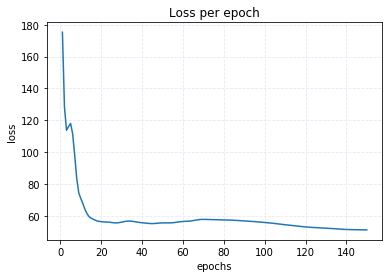

In [121]:
#epoch당 loss 그래프
epoch=np.linspace(1,150,150)
fig = plt.figure()
plt.plot(epoch,loss_save)
plt.xlabel('epochs')
plt.ylabel('loss')
plt.title('Loss per epoch')
plt.grid(linestyle='--', color='lavender')
plt.show()

In [ ]:
##########모델 검증

#최종loss
loss_value_train = sess.run(cost, feed_dict={X: x_train, Y: y_train})
loss_value_test = sess.run(cost, feed_dict={X: x_test, Y: y_test})     
print('epoch: {}/{}, train loss: {:.4f}, test loss: {:.4f}'.format(step+1, epochs, loss_value_train, loss_value_test))

#최종accuracy
accuracy = tf.reduce_mean(tf.cast(model, "float"))
train_accuracy = accuracy.eval(session = sess, feed_dict={X: x_train, Y: y_train})
test_accuracy = accuracy.eval(session = sess, feed_dict={X: x_test, Y: y_test})
print("Train Accuracy:", train_accuracy)
print("Test Accuracy:", test_accuracy)

In [123]:
##########모델 예측
y_predict = sess.run(model, feed_dict={X:x_test})

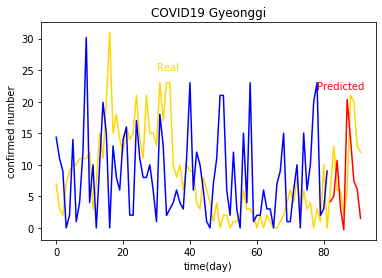

In [127]:
#예측된 값과 실제 값 비교 그래프
t=[82,83,84,85,86,87,88,89,90,91]

plt.title('COVID19 Gyeonggi')
plt.xlabel('time(day)')
plt.ylabel('confirmed number')

plt.text(30,25,'Real',color='gold')
plt.text(78,22,'Predicted',color='red')

y_predict_total = sess.run(model, feed_dict={X:x_train})
plt.plot(y,'gold',y_predict_total,'b',t,y_predict,'r')